In [103]:
import math
import re

import h5py
import matplotlib.pyplot as plt
import numpy as np
import trsfile
from tqdm import tqdm

from src.aes.hw_sbox import hw
from src.data.loaders import aisy
from src.data.preprocess.hw import full_states_hw
from src.tools.file import store_plt
from src.tools.lists import find
import seaborn as sns
from src.tools.plotter import store_sns, init_plots
from src.trace_set.database import Database
from src.trace_set.set_hw import TraceSetHW

init_plots()

In [18]:
random_title = "TVLA set Random CH0"
rand_ix = random_title.find("Random")

In [95]:
directory = "/data/AISy/"
filename = "traces.trs"

first_sample = 0
number_of_samples = 220000

# byte 0: tvla byte (0 or 1)
TVLA_BYTE = 0
# bytes 1 - 16: plaintext
PLAIN_IX = TVLA_BYTE + 1
# bytes 17 - 32: key
KEY_IX = PLAIN_IX + 16
# maybe plaintext and key are opposite, please check by doing a simple CPA attack if you think is necessary

data_length = 33

with trsfile.open(directory + filename) as trs_file:
    number_of_traces = len(trs_file)

    trs_samples = np.empty(shape=(number_of_traces, number_of_samples), dtype=np.int8)
    trs_hw_label_5 = np.empty(number_of_traces, dtype=bool)
    trs_plain = np.empty((number_of_traces, 16), dtype=np.uint8)
    trs_key = np.empty((number_of_traces, 16), dtype=np.uint8)

    for i, trace in tqdm(enumerate(trs_file), total=number_of_traces):
        trs_hw_label_5[i] = trace.data[TVLA_BYTE]
        trs_plain[i] = [b for b in trace.data[PLAIN_IX: PLAIN_IX + 16]]
        trs_key[i] = [b for b in trace.data[KEY_IX: KEY_IX + 16]]
        trs_samples[i, :] = trs_file[i][0:number_of_samples]

100%|██████████| 10000/10000 [00:00<00:00, 12178.17it/s]


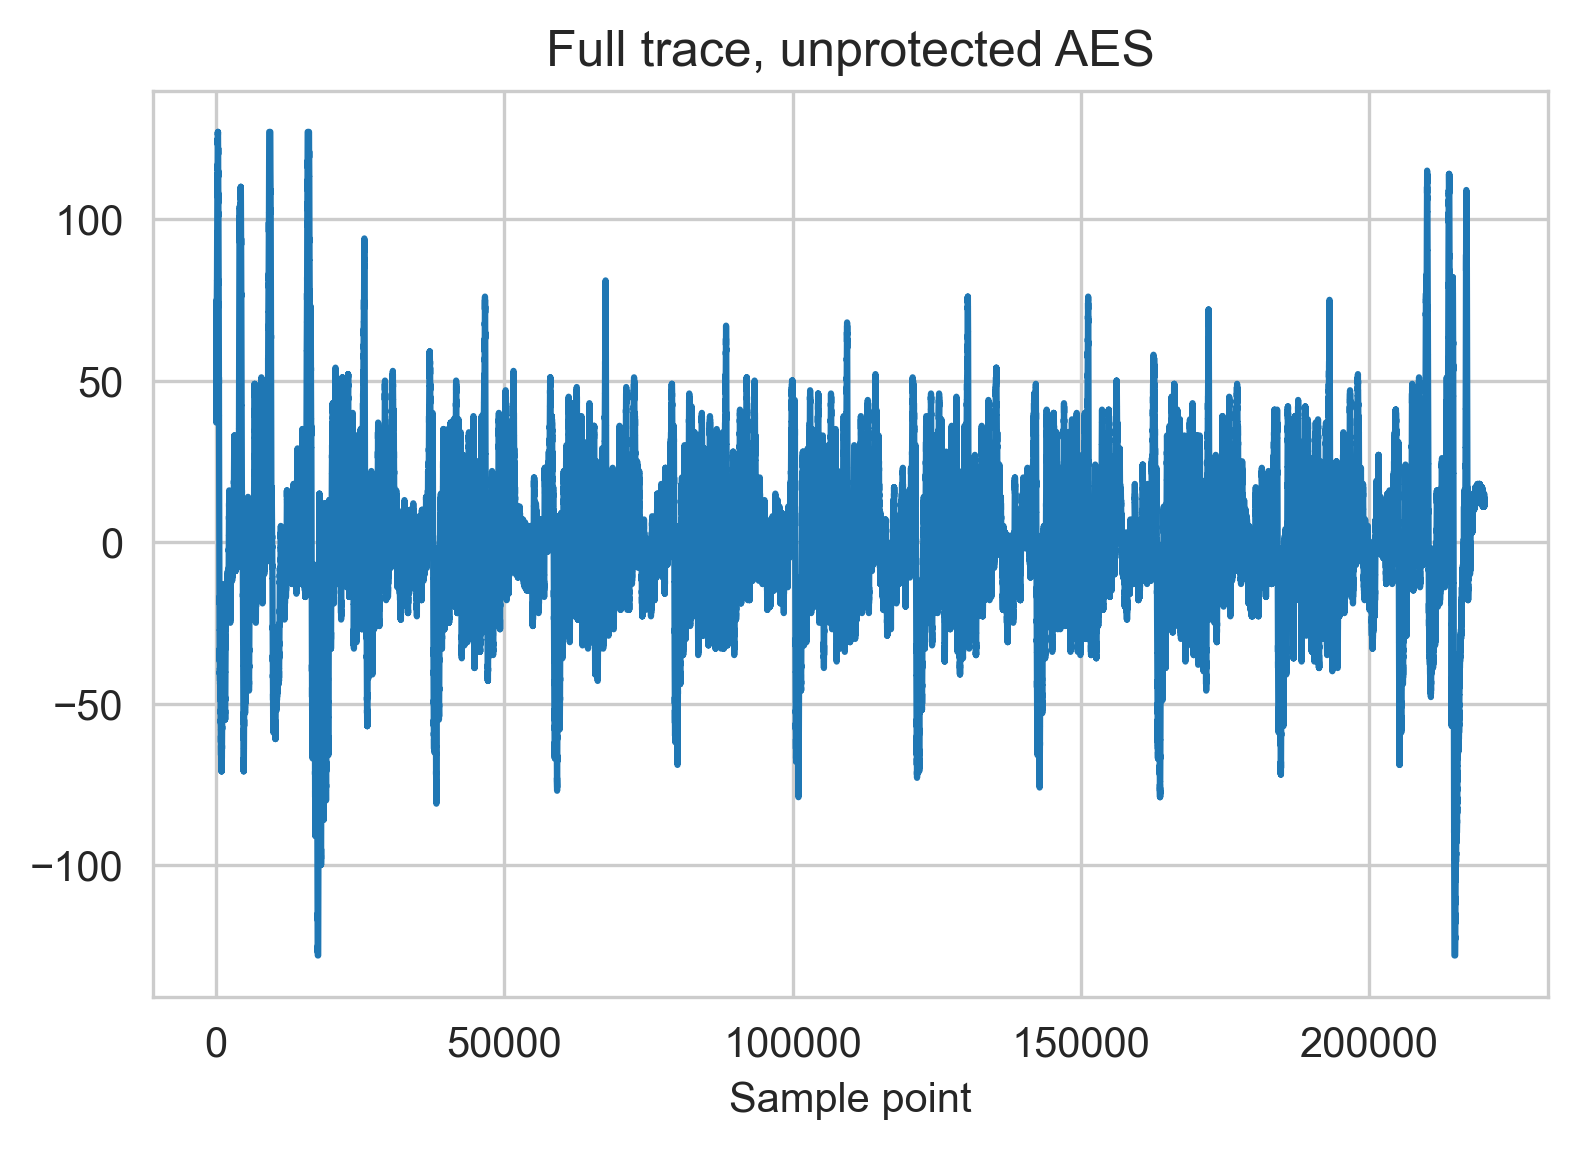

In [96]:
G = sns.lineplot(data=trs_samples[0])
G.set(title="Full trace, unprotected AES", xlabel="Sample point")
store_sns(G, "aisy-full-trace")

In [129]:
trs_plain[1]

array([ 56,  76, 255, 198,  93, 167,  74,   9, 144, 209, 214, 151,  40,
        57, 243,  73], dtype=uint8)

In [60]:
HWS_PLAIN = [hw(b[0]) for b in trs_plain]
HWS_KEY = [hw(b[0]) for b in trs_key]

np.bincount(HWS_PLAIN), np.bincount(HWS_KEY)

(array([  46,  315, 1131, 2232, 2716, 2136, 1054,  326,   44]),
 array([  44,  316, 1105, 2176, 2716, 2196, 1111,  293,   43]))

In [98]:
HWS = full_states_hw(trs_plain, trs_key)

100%|██████████| 10000/10000 [00:03<00:00, 3099.01it/s]


<AxesSubplot:>

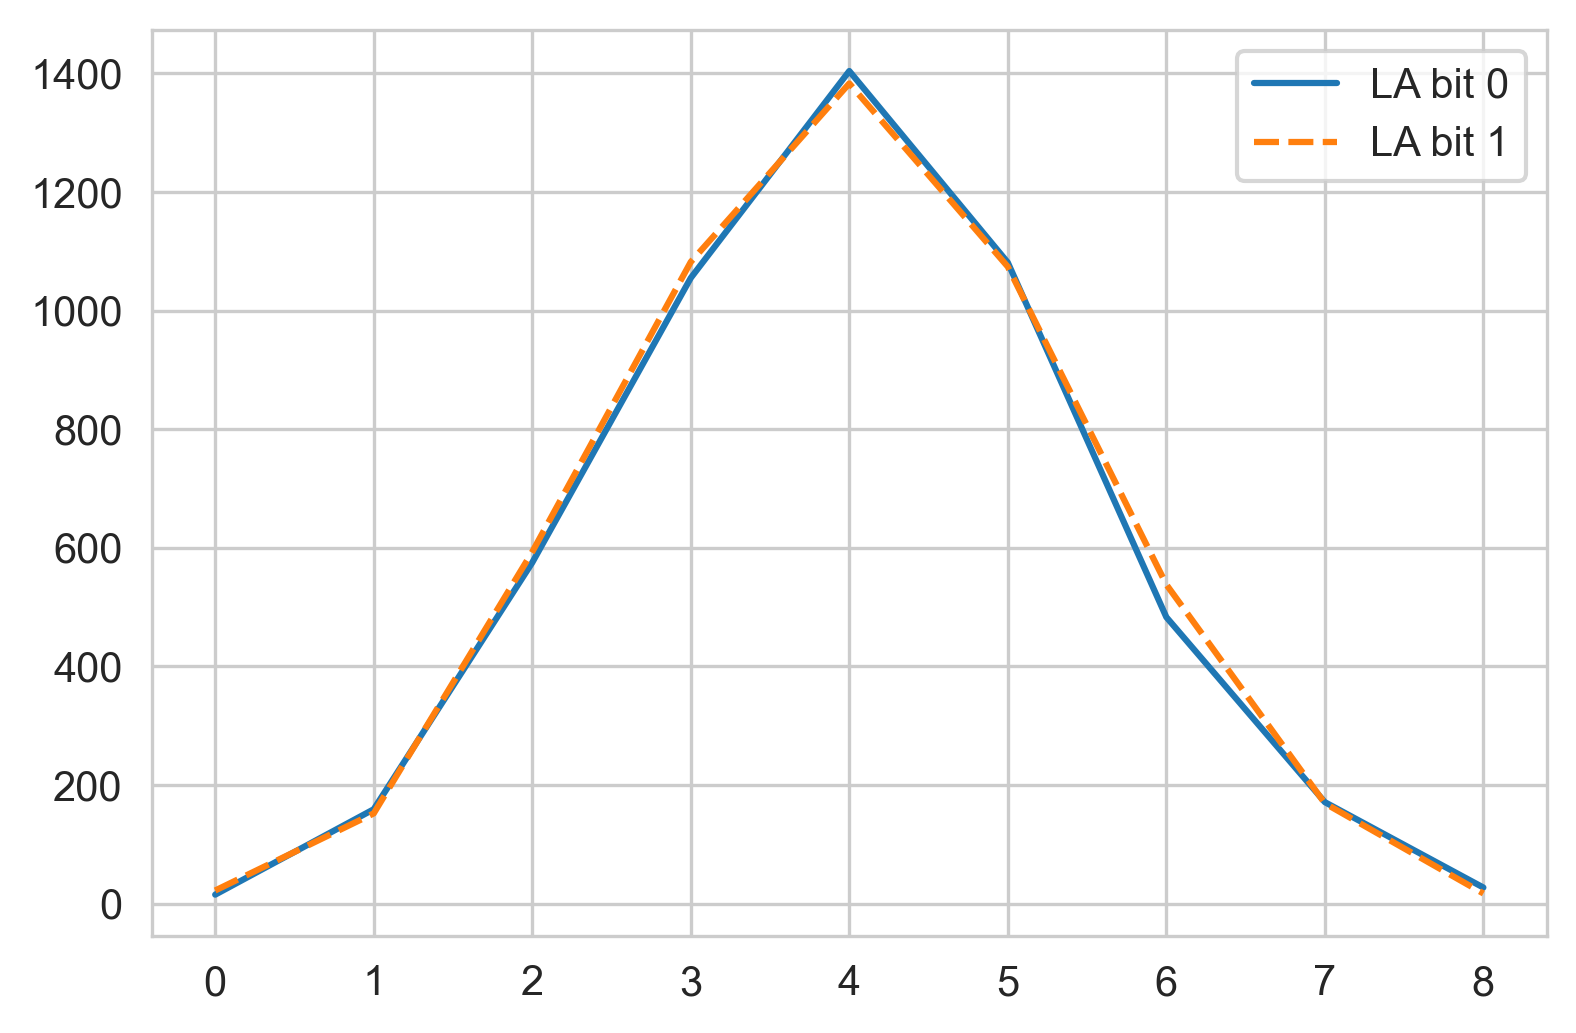

In [113]:
HWS_0 = HWS[:, 0, 0]
HWS_5 = HWS[:, 4, 0]

sns.lineplot(data={
    "LA bit 0": np.bincount(HWS_5[trs_hw_label_5 == 0], minlength=9),
    "LA bit 1": np.bincount(HWS_5[trs_hw_label_5 == 1], minlength=9),
})

In [114]:
SELECTION = np.zeros(number_of_traces, dtype=bool)
SELECTION[math.ceil(number_of_traces / 3):] = 1
np.random.shuffle(SELECTION)

TRS_PROF, TRS_PROF_HW = trs_samples[SELECTION], HWS_0[SELECTION]
TRS_ATT, TRS_ATT_HW = trs_samples[~SELECTION], HWS_0[~SELECTION]

In [115]:
TraceSetHW(Database.aisy).create(
    TRS_PROF, TRS_PROF_HW, TRS_ATT, TRS_ATT_HW
)

In [116]:
AISY = TraceSetHW(Database.aisy).open('r')
print(AISY['attack/hw'])
AISY.close()

<HDF5 dataset "hw": shape (3334,), type "|u1">
